# Task 1.2: Two Classes (Graduate and Dropout)
---

---

# Explore XAI techniques on the Student’s Dropout Dataset

**Course:** Advanced Topics in Machine Learning

**Group:** DS2-G3
        
    Alexandre Sousa: 202206427
    Magda Costa: 202207036
    Rafael Pacheco: 202206258

---

---

# Index  <a name = "index"></a>
1. [Introduction](#intro)
2. [Pre-Modelling Techniques](#pmt)
    - [Exploratory Analysis and Visualization (EDA)](#pmt_eda)
        - [Correlation Matrix and Heatmap](#pmt_eda_cm_h)
    - [Principal Component Analysis (PCA)](#pmt_pca)
            - [Normal PCA](#pmt_pca_normal)
            - [Kernel PCA](#pmt_pca_kernel)
        - [t - distributed Stochastic Neighbot Embedding (t-SNE)](#pmt_tsne)
            - [Normal t-SNE](#pmt_tsne_normal)
            - [t-SNE with Kernel PCA](#pmt_tsne_kernel_pca)
        - [Prototypes & Criticisms via MMD](#pmt_pc)

---

---

# Introduction <a name = "intro"></a>
[[go back to Index]](#index)

Through analysis of the complete data, we realized that the `Enrolled` class might be introducing a lot of noise. Therefore, this Jupyter project will reanalyze the dataset without that class to see if there is a better division between the remaining classes.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from IPython.display import display
from dataclasses import dataclass
from typing import List, Sequence
from sklearn.metrics.pairwise import pairwise_kernels
from scipy.stats import chi2_contingency

---

We start by reading the dataset and selecting only the data related to the Dropout and Graduate classes.

In [2]:
data = pd.read_csv('data_all_preprocessed.csv')

In [3]:
# Filtra mantendo apenas Target != 
data_all = data.copy()
data = data[data["Target"] != 2]
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,1
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,1
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,1


In [4]:
print("Format (rows, columns):", data.shape)

Format (rows, columns): (3630, 37)


In [5]:
data.to_csv("data.csv", index=False)

# Pre-Modelling Techniques <a name = "pmt"></a>
[[go back to Index]](#index)

## Exploratory Analysis and Visualization (EDA)  <a name = "pmt_eda"></a>
[[go back to Pre-Modelling Techniques]](#pmt)

### Correlation Matrix and Heatmap <a name = "pmt_eda_cm_h"></a>
[[go back to EDA]](#pmt_eda)

**Step 01: Divide the features**

Let's first separate the features into two major groups: 

- Numerical features with linearity: This includes continous features and features that were not previously label encoded to be numeric, when they act as categorical. 

- Numerical features wint non-linearity: All the features that were label encoded. We'll include here the binary features also.

In [6]:
numeric_cols = [
    'Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP',
]

categorical_cols = [
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Marital status',
    'Application order',
    'Daytime/evening attendance\t',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International',
    'Target',
]

print("Numeric (Pearson):", numeric_cols)
print("Categorical (Cramér's V):", categorical_cols)

Numeric (Pearson): ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP']
Categorical (Cramér's V): ['Application mode', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Marital status', 'Application order', 'Daytime/evening attendance\t', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship h

**Step 02: Use Person Correlation to Numerical features with linearity**

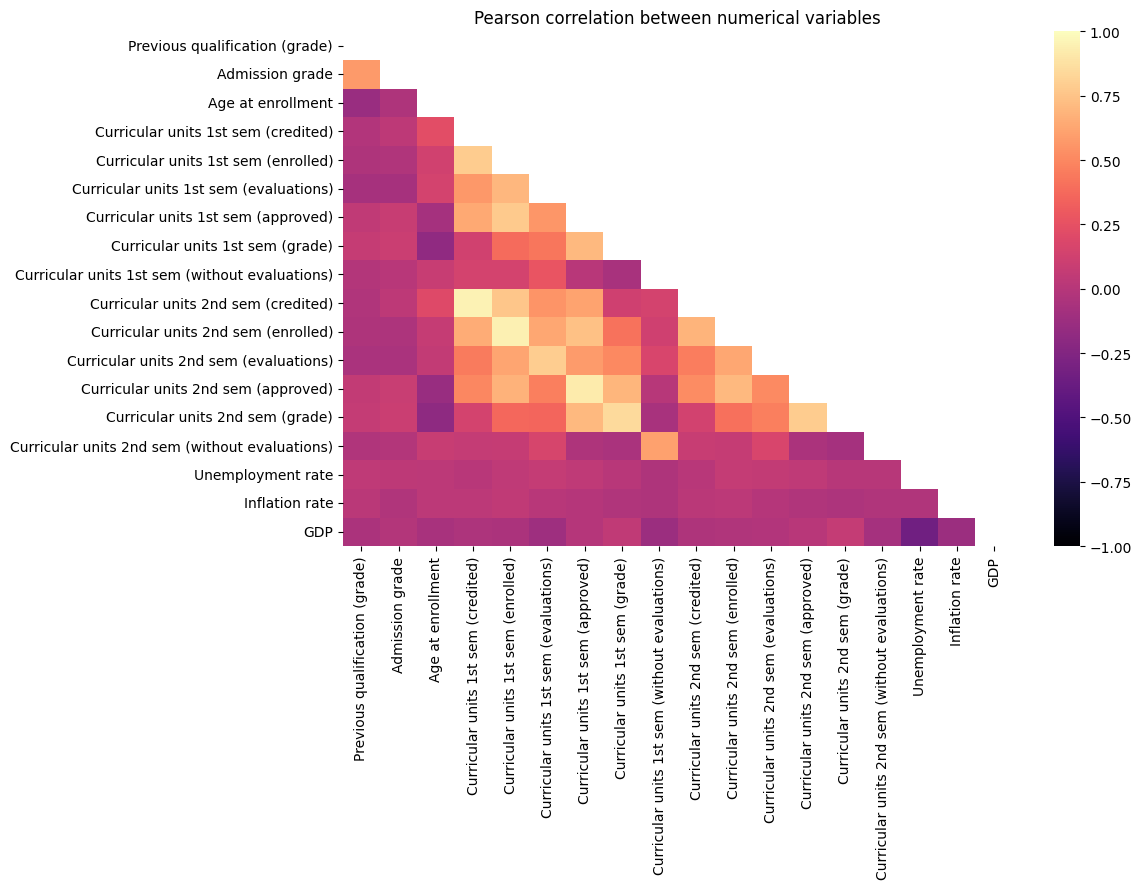

In [7]:
# Matriz de correlação de Pearson entre variáveis numéricas
num = data[numeric_cols]
pearson_mat = num.corr(method="pearson")

mask = np.triu(np.ones_like(pearson_mat, dtype=bool))

plt.figure(figsize=(12, 9))
sns.heatmap(
    pearson_mat,
    mask=mask,
    cmap="magma",
    vmin=-1,
    vmax=1,
    annot=False  # põe True se quiseres ver os valores
)
plt.title("Pearson correlation between numerical variables")
plt.tight_layout()
plt.show()

After removing class 3, the overall correlation structure between the numerical variables remains largely unchanged. The strong block of correlations among academic performance indicators is still present, reflecting the consistency of students’ progress across semesters. The matrix appears slightly more stable and coherent, which is expected given that class 3 previously introduced considerable variability due to its heterogeneous nature. Macroeconomic variables continue to show near-zero correlations with the academic features. Overall, the removal of class 3 clarifies the intrinsic relationships within the dataset without altering their fundamental interpretation.

> **See correlation with the target**

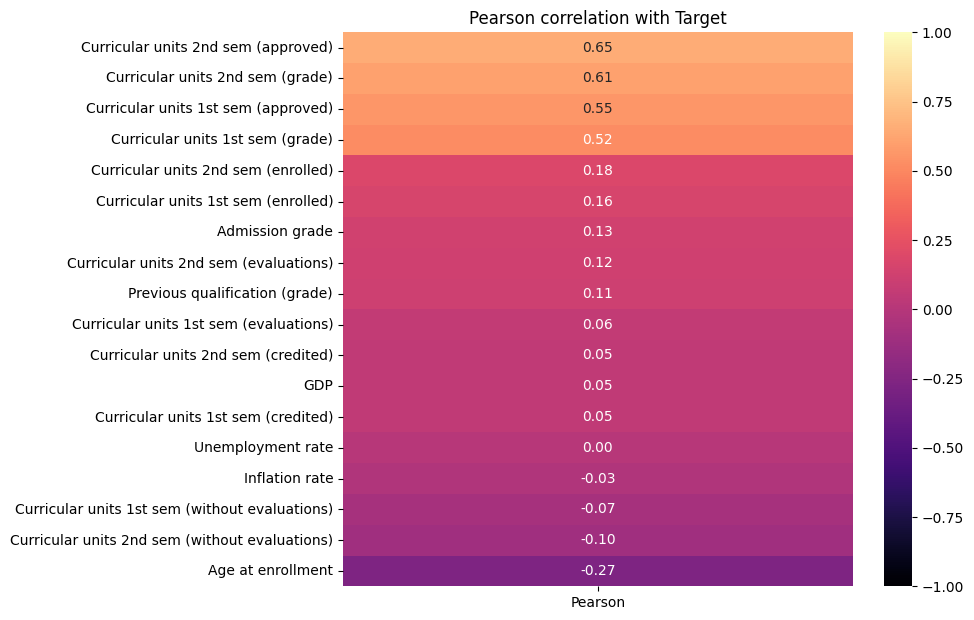

In [8]:
"""
Distance correlation entre cada feature numérica e o target.
"""
target_col = "Target"

# Usa só as features numéricas que queres (ex.: numeric_cols) + Target
num = data[numeric_cols + [target_col]]

# Correlação de Pearson de cada feature com o target (point-biserial)
target_pearson = (
    num.drop(columns=[target_col])
       .corrwith(num[target_col])
       .sort_values(ascending=False)
)

corr_target_only = target_pearson.to_frame(name="Pearson")

plt.figure(figsize=(10, max(3, len(corr_target_only)*0.35)))
sns.heatmap(
    corr_target_only,
    cmap="magma",
    center=0,
    annot=True,
    fmt=".2f",
    cbar=True,
    vmin=-1,
    vmax=1,
)
plt.title(f"Pearson correlation with {target_col}")
plt.tight_layout()
plt.show()

The correlations between the numerical variables and the target become much clearer and substantially stronger. Academic performance indicators now dominate the correlation structure, with second-semester approvals and grades showing coefficients above 0.60, and first-semester performance also contributing strongly. This reflects a much more coherent and interpretable relationship between the target and students’ actual academic progression.

Variables related to enrolment show moderate correlations, while background and macroeconomic variables exhibit near-zero influence, suggesting that the distinction between the two remaining classes is driven almost entirely by academic behaviour rather than external factors. Age at enrolment now shows a meaningful negative correlation. Overall, removing class 3 eliminates much of the noise and reveals a clean, interpretable structure in the data.

**Step 03: Cormers' V to Numerical features that were previously label encoded**

c:\Users\magda.costa\MIA\TAAC\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\magda.costa\MIA\TAAC\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


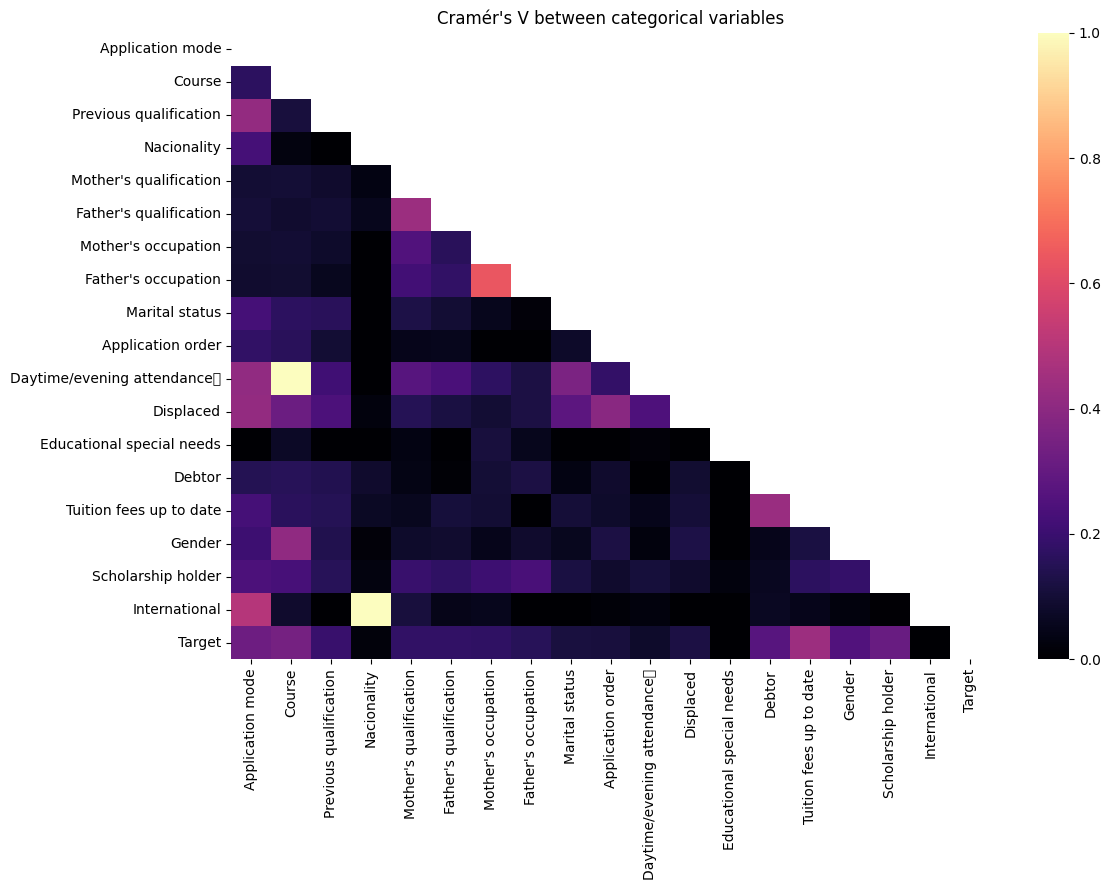

In [9]:
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion)
    n = confusion.to_numpy().sum()

    phi2 = chi2 / n
    r, k = confusion.shape

    # correção de viés (Bergsma 2013)
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    r_corr = r - ((r - 1)**2)/(n - 1)
    k_corr = k - ((k - 1)**2)/(n - 1)

    denom = min((k_corr - 1), (r_corr - 1))
    if denom <= 0:
        return 0.0

    return np.sqrt(phi2_corr / denom)

def cramers_v_matrix(df, cat_cols):
    m = len(cat_cols)
    res = pd.DataFrame(np.ones((m, m)), index=cat_cols, columns=cat_cols)
    for i in range(m):
        for j in range(i + 1, m):
            v = cramers_v(df[cat_cols[i]], df[cat_cols[j]])
            res.iloc[i, j] = v
            res.iloc[j, i] = v
    return res   # <-- aqui

# usar
cat = data[categorical_cols]
cramers_mat = cramers_v_matrix(cat, categorical_cols)

mask = np.triu(np.ones_like(cramers_mat, dtype=bool))

plt.figure(figsize=(12, 9))
sns.heatmap(
    cramers_mat,
    mask=mask,
    cmap="magma",
    vmin=0,
    vmax=1,
    annot=False
)
plt.title("Cramér's V between categorical variables")
plt.tight_layout()
plt.show()

The Cramér’s V matrix remains largely unchanged after removing class 3, as categorical–categorical associations are not directly affected by the target distribution. Most variables show very low association values, indicating that the categorical features capture mostly independent aspects of the students’ profiles. The few moderate relationships that appear, such as nationality with international status or parental qualification with parental occupation, remain consistent and reflect natural socio-demographic links.

> **See correlation with the target**

In [10]:
target_col = "Target"

# Cramér's V de cada variável categórica com a Target
target_cramers = (
    pd.Series(
        {
            col: cramers_v(data[col], data[target_col])
            for col in categorical_cols
            if col != target_col
        }
    )
    .sort_values(ascending=False)
)

target_cramers

Tuition fees up to date         0.441057
Course                          0.342998
Application mode                0.321483
Scholarship holder              0.311981
Debtor                          0.265837
Gender                          0.250847
Previous qualification          0.192584
Mother's qualification          0.178020
Father's qualification          0.177900
Mother's occupation             0.174282
Father's occupation             0.152518
Displaced                       0.124461
Marital status                  0.115163
Application order               0.113273
Daytime/evening attendance\t    0.081949
Nacionality                     0.022553
Educational special needs       0.000000
International                   0.000000
dtype: float64

The association between the categorical features and the target also remains weak, confirming that the distinction between the remaining classes is not driven by demographic or administrative categories but primarily by academic performance. Overall, the categorical structure becomes slightly cleaner, but its fundamental interpretation remains the same.

**Step 04: Correlation between Binary Features and Numerical Features with Linearity**

In [11]:
# categorical_cols is your list of categorical features (including yes/no)
binary_cols = [
    col for col in categorical_cols
    if data[col].nunique(dropna=True) == 2
]

print("Binary features:", binary_cols)

Binary features: ['Daytime/evening attendance\t', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International', 'Target']


c:\Users\magda.costa\MIA\TAAC\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\magda.costa\MIA\TAAC\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


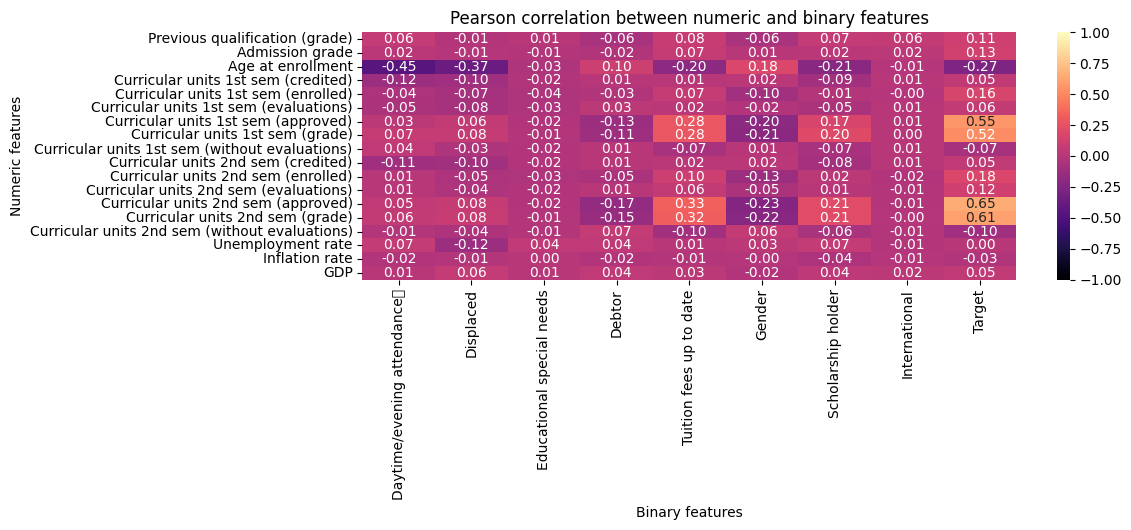

In [12]:
# Convert them to 0/1 (if needed)
bin_df = data[binary_cols].copy()

for col in binary_cols:
    s = bin_df[col]
    if pd.api.types.is_numeric_dtype(s):
        # already numeric (e.g. 0/1)
        continue
    # convert categories to 0,1
    bin_df[col] = pd.factorize(s)[0]

# Numeric features with linearity
numeric_df = data[numeric_cols]

# Pearson correlation: numeric × binary
corr_num_bin = pd.DataFrame(
    {
        b: numeric_df.corrwith(bin_df[b])   # <-- here was the bug
        for b in binary_cols
    },
    index=numeric_cols,
)


plt.figure(figsize=(12, max(4, len(numeric_cols) * 0.3)))
sns.heatmap(
    corr_num_bin,
    cmap="magma",
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,   # mete False se não quiseres os números escritos
    fmt=".2f",
    cbar=True
)
plt.title("Pearson correlation between numeric and binary features")
plt.xlabel("Binary features")
plt.ylabel("Numeric features")
plt.tight_layout()
plt.show()

The correlation matrix between numerical and binary variables shows that, after removing class 3, the relationships become more stable but remain generally weak. Most binary features, such as gender, scholarship status, international status, and special needs, exhibit near-zero correlations with academic performance measures. This confirms that demographic and administrative variables do not meaningfully explain students’ academic outcomes.

The only binary variable showing a moderate association with academic performance is “tuition fees up to date”, which correlates positively with grades and approved curricular units. This may reflect underlying financial stability or consistent administrative engagement rather than a causal effect. Age at enrolment also retains a notable negative correlation with performance-related indicators, suggesting that older students tend to achieve lower outcomes. Overall, the cleaned dataset reinforces that academic behaviour is the primary driver of class distinction and not demographic attributes.

---
---

# Principal Component Analysis (PCA) <a name = "pmt_pca"></a>
[[go back to Pre-Modelling Techniques]](#pmt)

---

## Normal PCA <a name = "pmt_pca_normal"></a>
[[go back to PCA]](#pmt_pca)

In [13]:
"""
This code prepares numeric features for modelling by standardising them.
"""

target = "Target"  
X = data.drop(columns=[target])
y = data[target]

X_num = X.select_dtypes(include=np.number)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

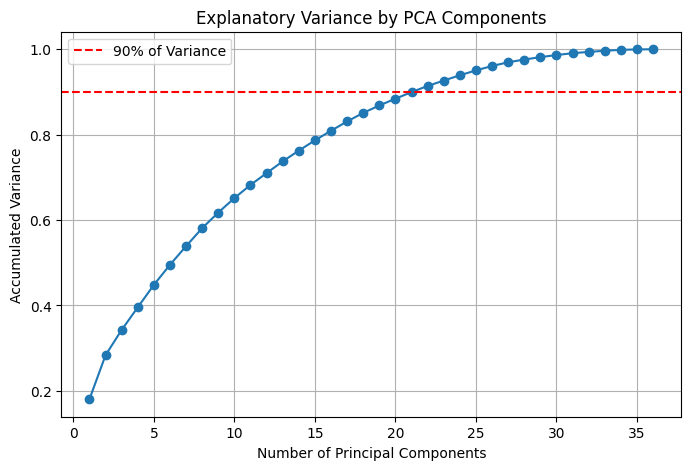

In [14]:
"""
This code applies PCA to the scaled features and plots how much variance is captured
as components are added.
"""

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance by component
explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% of Variance')
plt.title("Explanatory Variance by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accumulated Variance")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
"""
This code reduces the dimensionality of the scaled feature matrix using PCA.
"""

pca = PCA(n_components=21)
X_reduced = pca.fit_transform(X_scaled)

print(f"Original Form: {X_scaled.shape}")
print(f"After PCA: {X_reduced.shape}")

Original Form: (3630, 36)
After PCA: (3630, 21)


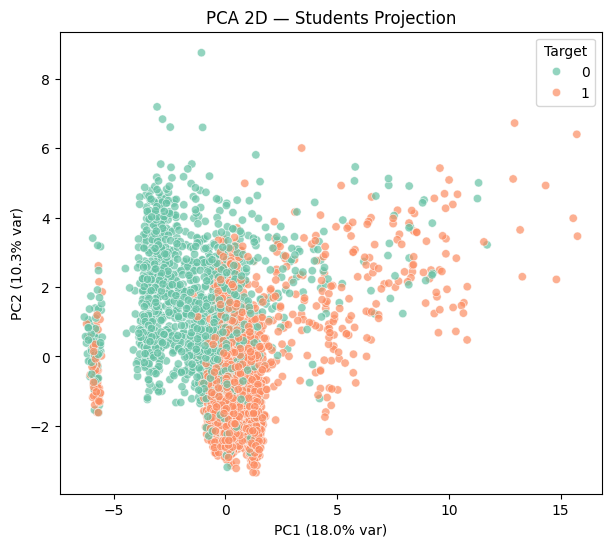

In [16]:
"""
This code projects the scaled data into two principal components and visualises
the result coloured by the target class.
"""

pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_2d, columns=['PC1', 'PC2'])
pca_df[target] = y.values

plt.figure(figsize=(7,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=target, palette='Set2', alpha=0.7)
plt.title("PCA 2D — Students Projection")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title=target)
plt.show()

The PCA also yields essentially the same results, with a clearer 2D projection since the "Enrolled" label is not present. Since the PCA is related to data representativeness, and the "Enrolled" label essentially added only noise, there are no significant differences.

---

## Kernel PCA <a name = "pmt_pca_kernel"></a>
[[go back to PCA]](#pmt_pca)

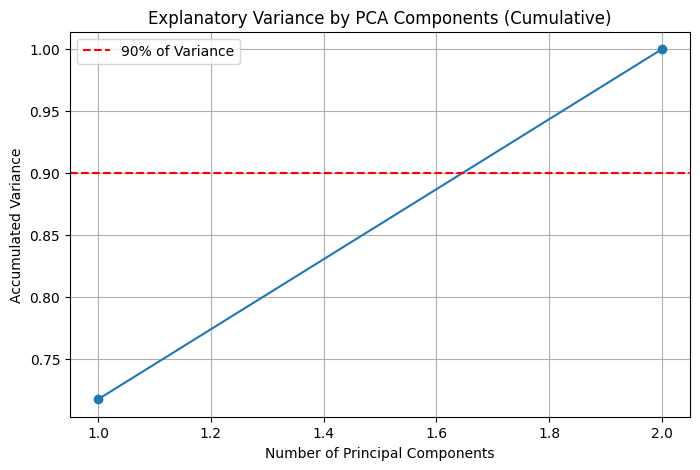

In [17]:
kpca = KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=0.05,
    fit_inverse_transform=False,
    random_state=0,
)
X_kpca = kpca.fit_transform(X_scaled)

# pegar autovalores de forma compatível
eigs = getattr(kpca, "lambdas_", None)
if eigs is None:
    eigs = getattr(kpca, "eigenvalues_", None)
    if eigs is None:
        raise AttributeError("KernelPCA não retornou autovalores (lambdas_/eigenvalues_).")

explained_var = eigs / eigs.sum()
explained_var_cum = np.cumsum(explained_var)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var_cum) + 1), explained_var_cum, marker="o")
plt.axhline(y=0.9, color="r", linestyle="--", label="90% of Variance")
plt.title("Explanatory Variance by PCA Components (Cumulative)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accumulated Variance")
plt.legend()
plt.grid(True)
plt.show()

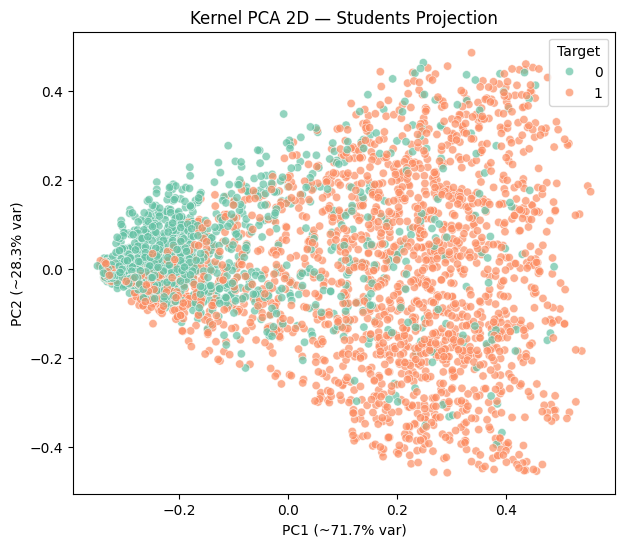

In [18]:
kpca_2d = KernelPCA(n_components=2, kernel="rbf", gamma=0.05, random_state=0)
X_2d = kpca_2d.fit_transform(X_scaled)

# autovalores (lambda) para proxy de variância explicada
eigs = getattr(kpca_2d, "lambdas_", None) or getattr(kpca_2d, "eigenvalues_", None)
if eigs is None:
    raise AttributeError("KernelPCA não retornou autovalores (lambdas_/eigenvalues_).")
ratio = eigs / eigs.sum()

kpca_df = pd.DataFrame(X_2d, columns=["PC1", "PC2"])
kpca_df[target] = y.values

plt.figure(figsize=(7, 6))
sns.scatterplot(data=kpca_df, x="PC1", y="PC2", hue=target, palette="Set2", alpha=0.7)
plt.title("Kernel PCA 2D — Students Projection")
plt.xlabel(f"PC1 (~{ratio[0]*100:.1f}% var)")
plt.ylabel(f"PC2 (~{ratio[1]*100:.1f}% var)")
plt.legend(title=target)
plt.show()

After removing class 3, the PCA projection reveals a much clearer separation between the remaining two classes. Class 0 forms a compact and homogeneous cluster on the negative side of PC1, while class 1 occupies the broader, more dispersed region on the positive side. PC1 continues to explain the majority of the variance and represents a strong linear gradient of academic performance, directly aligning with the target distinction. PC2 accounts for subtler internal differences but does not contribute meaningfully to class separation. Overall, the PCA structure becomes far more coherent and interpretable, confirming that the removed class introduced substantial noise and masked the underlying relationships in the data.

# t-distributed Stochastic Neighbot Embedding (t-SNE) <a name = "pmt_tsne"></a>
[[go back to Pre-Modelling Techniques]](#pmt)

## Normal t-SNE <a name = "pmt_tsne_normal"></a>
[[go back to t-SNE]](#pmt_tsne)

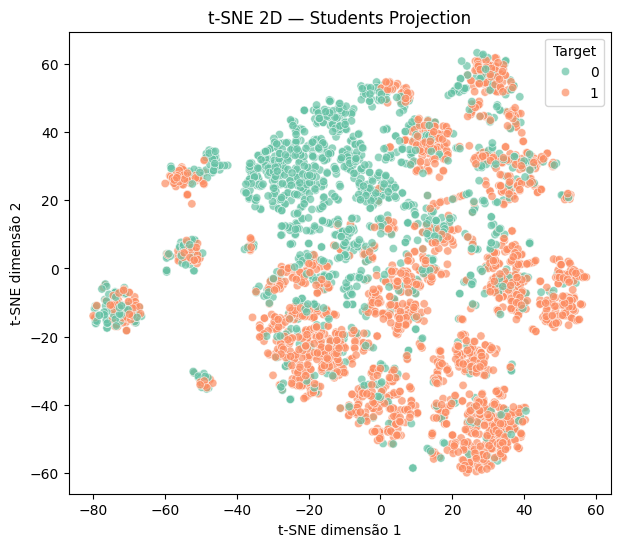

In [19]:
"""
This code runs t-SNE to create a 2D non-linear embedding of the scaled features
and visualises the result coloured by the target class.
"""

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42,
)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df[target] = y.values

plt.figure(figsize=(7, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue=target, palette='Set2', alpha=0.7)
plt.title('t-SNE 2D — Students Projection')
plt.xlabel('t-SNE dimensão 1')
plt.ylabel('t-SNE dimensão 2')
plt.legend(title=target, loc='best')
plt.show()

As with PCA, there is no significant difference in the t-SNE results, as expected for the same reasons. However, the data show a much clearer distinction, suggesting that classification models with only the labels "Graduated" and "Dropout" should achieve much better results.

## t-SNE with Kernel PCA <a name = "pmt_tsne_kernel_pca"></a>
[[go back to t-SNE]](#pmt_tsne)

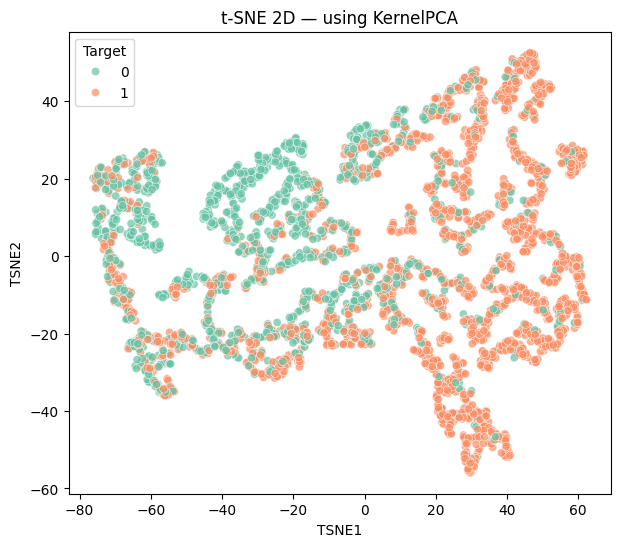

In [20]:
# t-SNE usando as PCs do KernelPCA
X_kpca_only = kpca_df.drop(columns=[target_col])
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
X_tsne_kpca = tsne.fit_transform(X_kpca_only)

tsne_kpca_df = pd.DataFrame(X_tsne_kpca, columns=["TSNE1", "TSNE2"], index=X_kpca_only.index)
tsne_kpca_df[target_col] = kpca_df[target_col].values

plt.figure(figsize=(7, 6))
sns.scatterplot(data=tsne_kpca_df, x="TSNE1", y="TSNE2", hue=target_col, palette="Set2", alpha=0.7)
plt.title("t-SNE 2D — using KernelPCA")
plt.show()

The t-SNE embedding applied to the Kernel PCA components reveals an exceptionally clear separation between the two remaining classes. Each class forms a continuous and well-defined region, with minimal overlap and only internal sub-structure. This demonstrates that the distinction between classes 0 and 1 follows a highly non-linear geometry that Kernel PCA successfully captures before t-SNE refines the local neighbourhood structure.

Compared with earlier visualisations (PCA, Kernel PCA alone, or t-SNE on the raw data), this representation is by far the most separable. The results indicate that the two classes are strongly distinguishable by non-linear models, and that the removal of class 3 eliminates the noise that previously obscured this structure.

## Prototypes & Criticisms via MMD <a name = "pmt_pc"></a>
[[go back to Pre-Modelling Techniques]](#pmt)

Maximum Mean Discrepancy (MMD) gives us a kernel-based way to summarise the dataset with representative examples (prototypes) and to highlight under-represented, atypical points (criticisms). The plot below projects the full dataset to two principal components and overlays the selected samples.


In [21]:
"""Utilities to extract prototypes and criticisms with Maximum Mean Discrepancy.

This module implements the greedy selection strategy proposed in:
  "Examples are not Enough, Learn to Criticize! Criticism for Interpretability"
  (Been Kim, Rajiv Khanna, Oluwasanmi Koyejo, 2016).
"""

@dataclass
class MMDSelectionResult:
    """Indices for the selected prototypes and criticisms."""

    prototypes: List[int]
    criticisms: List[int]


def _kernel_matrix(
    X: np.ndarray,
    kernel: str = "rbf",
    gamma: float | None = None,
) -> np.ndarray:
    """Build the kernel matrix for the dataset."""
    params = {"metric": kernel}
    if gamma is not None:
        params["gamma"] = gamma
    return pairwise_kernels(X, **params)


def _select_prototypes_from_kernel(
    K: np.ndarray,
    m: int,
) -> List[int]:
    """Greedy selection of prototypes that minimise the MMD to the full dataset."""
    n = K.shape[0]
    if m <= 0 or m > n:
        raise ValueError("`m` must be between 1 and the number of samples.")

    selected: List[int] = []
    selected_set: set[int] = set()
    kernel_row_sums = K.sum(axis=1)
    dataset_size = float(n)
    sum_K_S = 0.0  # Sum of kernel values between selected elements and the dataset.
    sum_KSS = 0.0  # Sum of kernel values between selected elements.

    for t in range(m):
        best_idx = -1
        best_score = -np.inf
        best_sum_K_S_new = None
        best_sum_KSS_new = None

        denom_ds = dataset_size * (t + 1)
        denom_ss = float((t + 1) ** 2)

        for i in range(n):
            if i in selected_set:
                continue
            sum_K_S_new = sum_K_S + kernel_row_sums[i]
            cross_term = 0.0 if not selected else float(K[i, selected].sum())
            sum_KSS_new = sum_KSS + K[i, i] + 2.0 * cross_term

            score = (2.0 / denom_ds) * sum_K_S_new - (1.0 / denom_ss) * sum_KSS_new
            if score > best_score:
                best_score = score
                best_idx = i
                best_sum_K_S_new = sum_K_S_new
                best_sum_KSS_new = sum_KSS_new

        selected.append(best_idx)
        selected_set.add(best_idx)
        sum_K_S = best_sum_K_S_new  # type: ignore[assignment]
        sum_KSS = best_sum_KSS_new  # type: ignore[assignment]

    return selected


def _select_criticisms_from_kernel(
    K: np.ndarray,
    prototype_indices: Sequence[int],
    n_criticisms: int,
    regularization: float = 1e-6,
) -> List[int]:
    """Pick the data points with the largest witness function values."""
    n = K.shape[0]
    available = sorted(set(range(n)) - set(prototype_indices))
    if n_criticisms <= 0:
        return []
    if not available:
        raise ValueError("No candidates left to choose criticisms from.")

    kernel_mean = K.mean(axis=1)
    proto_kernel = K[:, prototype_indices] if prototype_indices else np.zeros((n, 0))
    proto_mean = proto_kernel.mean(axis=1) if prototype_indices else np.zeros(n)
    witness = kernel_mean - proto_mean

    scores = witness[available] ** 2 / (regularization + np.diag(K)[available])
    ordering = np.argsort(scores)[::-1]

    selected = [available[i] for i in ordering[:n_criticisms]]
    return selected


def select_mmd_prototypes_and_criticisms(
    X: np.ndarray,
    n_prototypes: int,
    n_criticisms: int,
    kernel: str = "rbf",
    gamma: float | None = None,
    regularization: float = 1e-6,
) -> MMDSelectionResult:
    """Select prototypes and criticisms using the MMD objective.

    Parameters
    ----------
    X:
        Input matrix with shape (n_samples, n_features).
    n_prototypes:
        Number of prototypes to select.
    n_criticisms:
        Number of criticisms to select.
    kernel:
        Any kernel supported by ``sklearn.metrics.pairwise_kernels`` (default ``rbf``).
    gamma:
        Optional gamma parameter for kernels such as RBF.
    regularization:
        Stabilises the criticism scoring; must be > 0.
    """
    if X.ndim != 2:
        raise ValueError("`X` must be a 2D array.")

    K = _kernel_matrix(X, kernel=kernel, gamma=gamma)
    proto_indices = _select_prototypes_from_kernel(K, n_prototypes)
    criticism_indices = _select_criticisms_from_kernel(
        K,
        proto_indices,
        n_criticisms=n_criticisms,
        regularization=regularization,
    )
    return MMDSelectionResult(prototypes=proto_indices, criticisms=criticism_indices)

In [22]:
# Prepare feature matrix
features = data.copy()
features.columns = features.columns.str.strip()
feature_cols = [col for col in features.columns if col != "Target"]
X = features[feature_cols].to_numpy(dtype=float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selection = select_mmd_prototypes_and_criticisms(
    X_scaled,
    n_prototypes=10,
    n_criticisms=5,
    kernel="rbf",
    gamma=None,
    regularization=1e-6,
)

prototypes_df = features.iloc[selection.prototypes].assign(kind="Prototype")
criticisms_df = features.iloc[selection.criticisms].assign(kind="Criticism")

display(prototypes_df)
display(criticisms_df)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,kind
46,1,17,2,9238,1,1,130.0,1,19,19,...,6,8,5,13.200000,0,11.1,0.6,2.02,1,Prototype
876,1,17,1,9070,1,1,119.0,1,38,19,...,6,7,5,11.000000,0,15.5,2.8,-4.06,0,Prototype
753,2,39,1,9991,0,19,133.1,1,19,37,...,5,6,0,0.000000,0,10.8,1.4,1.74,0,Prototype
4205,1,1,3,9500,1,1,154.0,1,1,37,...,7,7,6,13.533333,0,7.6,2.6,0.32,1,Prototype
3527,1,43,1,9500,1,1,120.0,1,2,4,...,7,14,6,12.200000,0,13.9,-0.3,0.79,0,Prototype
3512,1,1,1,171,1,1,140.0,1,19,19,...,0,0,0,0.000000,0,10.8,1.4,1.74,0,Prototype
4214,1,1,2,9500,1,1,140.0,1,38,37,...,8,8,8,15.637500,0,13.9,-0.3,0.79,1,Prototype
2958,2,39,1,9853,1,19,133.1,1,37,19,...,6,13,2,11.000000,0,7.6,2.6,0.32,0,Prototype
125,1,17,6,9556,1,1,122.0,1,1,1,...,7,0,0,0.000000,0,13.9,-0.3,0.79,0,Prototype
4068,1,1,1,9670,1,1,154.0,1,1,1,...,5,5,5,12.600000,0,9.4,-0.8,-3.12,1,Prototype


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,kind
2516,1,17,1,9070,1,1,137.0,1,1,1,...,6,9,4,12.000000,0,9.4,-0.8,-3.12,1,Criticism
236,1,1,1,9853,1,1,148.0,1,19,19,...,6,7,6,13.166667,0,9.4,-0.8,-3.12,1,Criticism
2188,1,17,1,9254,1,1,140.0,1,3,1,...,6,9,3,12.666667,0,9.4,-0.8,-3.12,1,Criticism
133,1,17,6,9500,1,1,148.0,1,1,19,...,7,7,0,0.000000,0,13.9,-0.3,0.79,0,Criticism
1883,1,1,1,171,1,1,145.0,1,1,19,...,0,0,0,0.000000,0,10.8,1.4,1.74,1,Criticism


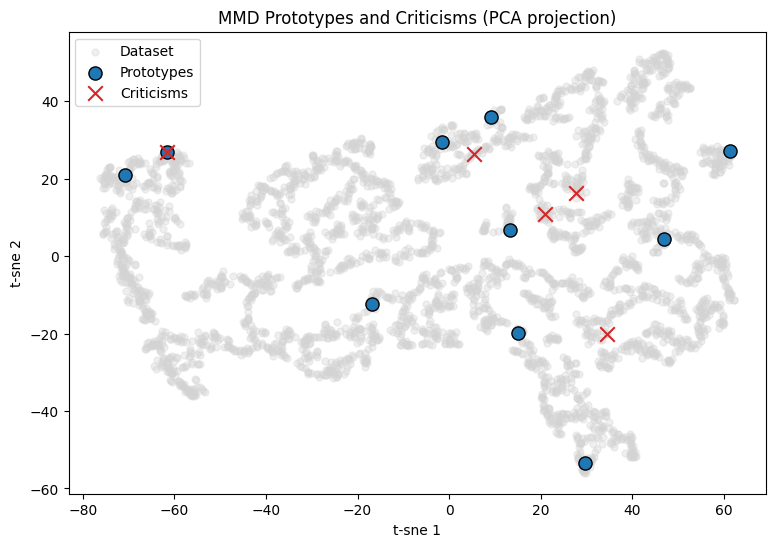

In [23]:
coords = tsne.fit_transform(kpca_df.drop(columns=[target_col]).to_numpy())

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(coords[:, 0], coords[:, 1], color="lightgrey", alpha=0.35, s=25, label="Dataset")
ax.scatter(
    coords[selection.prototypes, 0],
    coords[selection.prototypes, 1],
    color="tab:blue",
    edgecolor="black",
    s=90,
    label="Prototypes",
)
ax.scatter(
    coords[selection.criticisms, 0],
    coords[selection.criticisms, 1],
    color="tab:red",
    marker="x",
    s=110,
    label="Criticisms",
)
ax.set_title("MMD Prototypes and Criticisms (PCA projection)")
ax.set_xlabel("t-sne 1")
ax.set_ylabel("t-sne 2")
ax.legend(frameon=True, loc="best")
plt.show()

When we had the three classes, there was a dense and isolated region with many criticisms. By removing the Enroled class, the latent space became more cohesive and interpretable, with the criticisms now representing students who actually behave atypically within the two categories.

In [24]:
data.to_csv("data_preprocessed.csv", index=False)